ДЗ должна быть выполнена строго на torch:
1. использовать dataloader.
2. в цикл обучения добавить сохранения лучшей модели/шедулер для скорости обучения.
3. вывести графики обучения. Выводить информацию по обучению в процессе.

Решить задачу предсказания возраста. Свести к задаче классификации.

В качестве фьючеэкстрактора используйте любую вариацию vit.


In [ ]:
!pip3 install retina-face

In [1]:
from google.colab import drive
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from retinaface import RetinaFace
from torchvision import models
from torch.optim import AdamW
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import tarfile
import random
import shutil
import torch
import cv2
import os


In [2]:
def create_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path)


In [3]:
# connect to google drive
mount_point = '/content/drive'

create_dir(mount_point)
drive.mount(mount_point, force_remount=True)


Mounted at /content/drive


In [4]:
# init constants
PROJECT_PATH = '/content/drive/MyDrive/peleng-courses/HW_25'
ARCHIVE_PATH = '/content/drive/MyDrive/peleng-courses/HW_25/wiki.tar.gz'

NET_SIZE = (1, 3, 224, 224)
SIZE_TH = 0.3

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1

BATCH_SIZE = 256


In [ ]:
# function for find path to extracted images
def find_extracted():
    for folder in os.listdir(PROJECT_PATH):
        folder_path = os.path.join(PROJECT_PATH, folder)

        if os.path.isdir(folder_path) and \
                'cropped' not in folder and \
                'weights' not in folder:
            return folder_path

    return None


In [ ]:
# function for find extracted or extract images
def extract_wiki():
    extracted_path = find_extracted()

    if extracted_path is not None:
        return extracted_path

    with tarfile.open(ARCHIVE_PATH, 'r') as wiki_tar:
        wiki_tar.extractall(PROJECT_PATH)

    return find_extracted()


In [ ]:
extracted_path = extract_wiki()
print('Extracted to', extracted_path)


Extracted to /content/drive/MyDrive/peleng-courses/HW_25/wiki


In [ ]:
# remove empty and non-3 channels images
for num_dir in tqdm(os.listdir(extracted_path)):
    num_dirpath = os.path.join(extracted_path, num_dir)

    if not os.path.isdir(num_dirpath): continue

    imgs_list = os.listdir(num_dirpath)
    for item in imgs_list:
        img_path = os.path.join(num_dirpath, item)
        img = cv2.imread(img_path)

        try:
            _, _, c = img.shape
            if c < 3: os.remove(img_path)
        except AttributeError:
            os.remove(img_path)


100%|██████████| 101/101 [27:41<00:00, 16.45s/it]


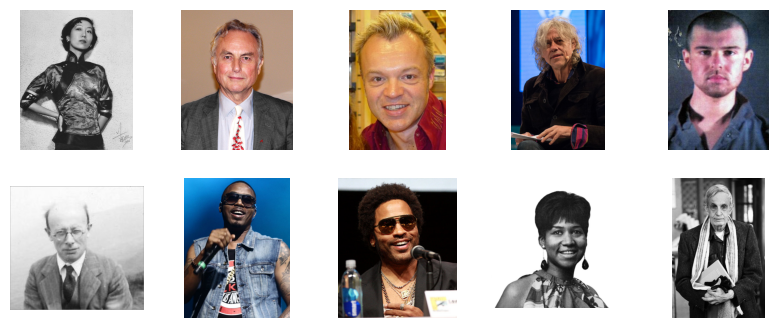

In [ ]:
# visualize extracted images
i = 0
plt.figure(figsize=(10, 4))

for num_dir in os.listdir(extracted_path):
    num_dir_path = os.path.join(extracted_path, num_dir)
    if not os.path.isdir(num_dir_path): continue

    for item in os.listdir(num_dir_path):
        if i >= 10: break

        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.imread(os.path.join(num_dir_path, item),
                   cv2.IMREAD_COLOR_RGB))
        plt.axis('off')
        i += 1

    if i >= 10: break


In [ ]:
# detect and crop faces from images
cropped_folder = extracted_path + '_cropped'
create_dir(cropped_folder)

images_df = pd.DataFrame(columns=['filepath', 'class'])
faces_model = RetinaFace.build_model()

for num_dir in tqdm(os.listdir(extracted_path)):
    num_dirpath = os.path.join(extracted_path, num_dir)

    if not os.path.isdir(num_dirpath):
        continue

    for item in os.listdir(num_dirpath):
        first_year, last_year = item.split('_')[-2:]
        first_year = int(first_year.split('-')[0])
        last_year = int(last_year.split('.')[0])
        delta_year = last_year - first_year

        if delta_year <= 0 or delta_year >= 100:
            continue

        img_path = os.path.join(num_dirpath, item)
        faces = RetinaFace.extract_faces(img_path=img_path,
                                         align=False,
                                         model=faces_model,
                                         allow_upscaling=False)
        for i, face in enumerate(faces):
            cropped_item = '.'.join(item.split('.')[:-1]) + f'{i}.png'
            cropped_path = os.path.join('/content', cropped_item)
            cropped_h, cropped_w = face.shape[:2]

            if cropped_h / NET_SIZE[2] < SIZE_TH or \
                    cropped_w / NET_SIZE[3] < SIZE_TH:
                continue

            if images_df.empty:
                images_df = pd.DataFrame(dict(zip(images_df.columns,
                 [cropped_path, int(delta_year / 10)])), index=[0])
            else:
                images_df = images_df._append(pd.Series(dict(zip(images_df.columns,
                 [cropped_path, int(delta_year / 10)]))), ignore_index=True)

            cv2.imwrite(cropped_path,
                        cv2.cvtColor(face, cv2.COLOR_RGB2BGR))


In [11]:
# images_df = pd.read_excel(os.path.join(PROJECT_PATH, 'images_set.xlsx'))


In [ ]:
# show dataframe for image set
images_df


,filepath,class
0,/content/wiki_cropped/31372_1900-01-25_19660.png,6
1,/content/wiki_cropped/93072_1951-10-07_20100.png,5
2,/content/wiki_cropped/48372_1907-12-15_19680.png,6
3,/content/wiki_cropped/32472_1943-03-29_20070.png,6
4,/content/wiki_cropped/147672_1970-02-14_20150.png,4
...,...,...
36675,/content/wiki_cropped/43848563_1920-06-13_1948...,2
36676,/content/wiki_cropped/44052363_1992-06-26_2013...,2
36677,/content/wiki_cropped/45299363_1990-03-05_2014...,2
36678,/content/wiki_cropped/45299563_1995-06-25_2013...,1


In [ ]:
# images_df.to_excel(os.path.join(PROJECT_PATH, 'images_set_content.xlsx'),
#                    index=False)


In [14]:
n_classes = len(images_df['class'].unique())


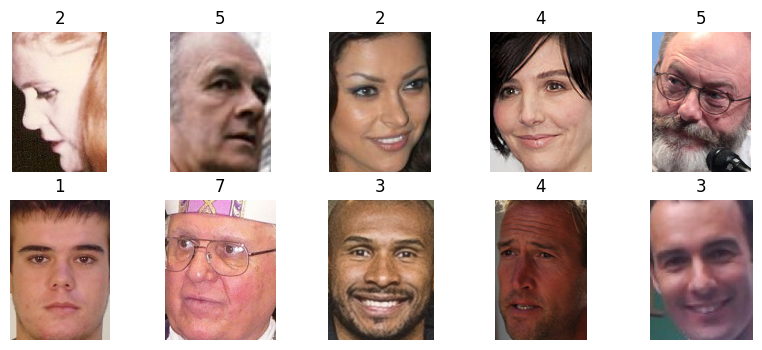

In [ ]:
# visualize cropped images
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.imread(images_df.iloc[i]['filepath'], cv2.IMREAD_COLOR_RGB))
    plt.axis('off')
    plt.title(images_df.iloc[i]['class'])


In [8]:
# create augmentations
augments = v2.Compose([
    v2.ColorJitter(0.2, 0.2, 0.2, 0.2),
    v2.RandomHorizontalFlip(p=0.6)
])


In [9]:
# create custom dataset class
class AgeDataset(Dataset):
    def __init__(self, dataset_df: pd.DataFrame, n_classes: int,
                 is_train: bool=False, augments=None):
        self.dataset_df = dataset_df
        self.transformer = models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms()
        self.n_classes = n_classes
        self.is_train = is_train
        self.augments = augments

        self.images = dict()

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx: int):
        if self.dataset_df.iloc[idx]['filepath'] not in self.images:
            img = cv2.imread(self.dataset_df.iloc[idx]['filepath'],
                             cv2.IMREAD_COLOR_RGB)
            img = torch.from_numpy(img).permute(2, 0, 1)

            self.images.update({self.dataset_df.iloc[idx]['filepath']: img})
        else:
            img = self.images[self.dataset_df.iloc[idx]['filepath']]

        if self.is_train and self.augments is not None:
            img = self.augments(img)
        img = self.transformer(img)

        lbl = torch.zeros(self.n_classes)
        lbl[self.dataset_df.iloc[idx]['class']] = 1.

        return img, lbl


In [12]:
# split image set into train, test and validation sets
idxes = list(images_df.index)
train_idxes = random.sample(idxes, int(TRAIN_SPLIT * len(images_df)))
test_val_idxes = set(idxes).difference(train_idxes)

val_idxes = random.sample(list(test_val_idxes), int(VAL_SPLIT * len(images_df)))
test_idxes = test_val_idxes.difference(val_idxes)

print('Training set size:', len(train_idxes),
      '\nValidation set size:', len(val_idxes),
      '\nTest set size:', len(test_idxes))

assert len(train_idxes) + len(val_idxes) + len(test_idxes) == len(idxes), '[WARNING] Wrong split'

train_df = images_df.iloc[list(train_idxes)].copy()
test_df = images_df.iloc[list(test_idxes)].copy()
val_df = images_df.iloc[val_idxes].copy()


Training set size: 25676 
Validation set size: 3668 
Test set size: 7336


In [15]:
# create train, test and validation dataloaders
train_dataset = AgeDataset(train_df, n_classes,
                           is_train=True, augments=augments)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = AgeDataset(test_df, n_classes)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataset = AgeDataset(val_df, n_classes)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)


In [ ]:
# download vit_b_16 model, add layers to heads, frozen vit_b layers
classifier_model = models.vit_b_16(image_size=224,
                                   weights=models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)

classifier_model.heads = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(768, n_classes),
)

for name, param in classifier_model.named_parameters():
    if not name.startswith('heads'):
        param.requires_grad = False

classifier_model


In [19]:
# check that layers are frozen, exclude heads layers
for param, val in classifier_model.named_parameters():
    if val.requires_grad:
        print(param)


heads.1.weight
heads.1.bias


In [20]:
# create optimizer and scheduler objects, define loss function
optimizer = AdamW(classifier_model.heads.parameters(), lr=0.001)
lr_scheduler_obj = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=3,
                                               eta_min=0.0001)
loss_fn = nn.CrossEntropyLoss()


In [21]:
# function for train model
def train_loop(model, epochs: int, optimizer, loss_fn, train_loader,
               val_loader, lr_shed, model_path: str):
    best_val_loss = None
    history = {'loss': list(), 'val_loss': list()}

    model.cuda()
    for epoch in range(epochs):
        print(f'Epochs {epoch}/{epochs}:', end='\t')

        model.train()
        last_train_loss = 0
        last_val_loss = 0

        for inputs, labels in tqdm(train_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            last_train_loss += loss.item()
            lr_shed.step()

        last_train_loss /= len(train_loader)
        history['loss'].append(last_train_loss)
        print(f'\ttrain_loss - {last_train_loss}', end='\t')

        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.cuda()
                val_labels = val_labels.cuda()

                val_outputs = model(val_inputs)
                val_loss = loss_fn(val_outputs, val_labels)
                last_val_loss += val_loss.item()

            last_val_loss /= len(val_loader)
            history['val_loss'].append(last_val_loss)
            print(f'val_loss - {last_val_loss}')

        if best_val_loss is None or last_val_loss < best_val_loss:
            best_val_loss = last_val_loss
            torch.save(model.state_dict(), model_path)

    print('[INFO] Train finished. Best model saved to ', model_path)

    return history


In [31]:
# train model
TRAIN_EPOCHS = 10

weights_path = os.path.join(PROJECT_PATH, 'weights')
create_dir(weights_path)
model_path = os.path.join(weights_path, 'model_best.pth')

history = train_loop(classifier_model, TRAIN_EPOCHS, optimizer,
                     loss_fn, train_loader,
                     val_loader, lr_scheduler_obj,
                     model_path)


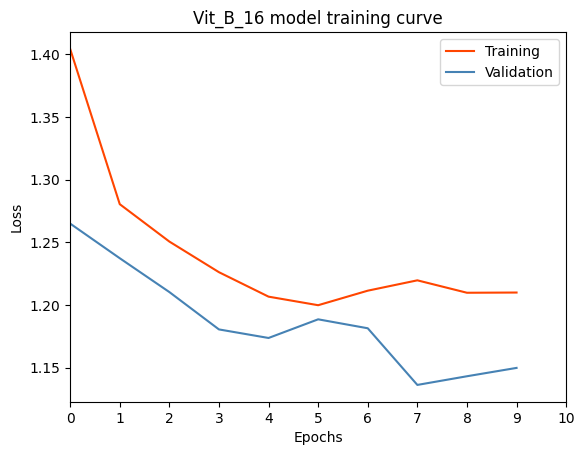

In [39]:
# show training curve
plt.plot(history['loss'], color='orangered')
plt.plot(history['val_loss'], color='steelblue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlim(0, TRAIN_EPOCHS)
plt.title('Vit_B_16 model training curve')
plt.legend(['Training', 'Validation'])
plt.show()


In [32]:
# load best model
best_model = classifier_model
best_model.load_state_dict(torch.load(model_path, weights_only=True))


<All keys matched successfully>

In [52]:
# evaluate model
last_test_loss = 0
sum_acc = 0

best_model.eval()
softmax_fn = nn.functional.softmax

with torch.no_grad():
    for test_inputs, test_labels in tqdm(test_loader):
        test_inputs = test_inputs.cuda()
        test_labels = test_labels.cuda()

        test_outputs = best_model(test_inputs)
        test_loss = loss_fn(test_outputs, test_labels)
        last_test_loss += test_loss.item()

        nn_classes = torch.argmax(softmax_fn(test_outputs, dim=1), dim=1)
        test_classes = torch.argmax(test_labels, dim=1)

        sum_acc += (nn_classes == test_classes).sum()

    last_test_loss /= len(test_loader)
    print(f'\nTest_loss - {last_test_loss}')

res_acc = sum_acc.item() / len(test_df)
print('Accuracy on test set:', res_acc)


100%|██████████| 29/29 [01:49<00:00,  3.76s/it]


Test_loss - 1.1761339491811291
Accuracy on test set: 0.5284896401308615


В процессе работы использована предобученная модель из torch - Vit_b_16. Предобученные веса для модели взяты из torch.models.ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1. Для оптимального обучения голова модели заменена на линейный слой классификации (10 классов), а все остальные слои заморожены. В процессе обучения использован CosineAnnealingWarmRestarts для регулировки скорости обучения, модель с меньшим лоссом на валидационной выборке сохранялась. При проверке на тестовой выборке достигнуты точность 0.5285 и лосс 1.1761.